In [1]:
import numpy as np
import os
import sys
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
%matplotlib inline 

src_path = os.path.abspath("../..")
if src_path not in sys.path:
    sys.path.append(src_path)
%load_ext autoreload
from dataset.kitti_odometry_dataset import KittiOdometryDataset, KittiOdometryDatasetConfig
from dataset.filters.filter_list import FilterList
from dataset.filters.kitti_gt_mo_filter import KittiGTMovingObjectFilter
from dataset.filters.range_filter import RangeFilter
from dataset.filters.apply_pose import ApplyPose

import scipy
from scipy.spatial.distance import cdist
from normalized_cut import normalized_cut
from ncuts_utils import ncuts_chunk,kDTree_1NN_feature_reprojection_colors, get_merge_pcds
from dataset_utils import * 
from point_cloud_utils import get_pcd, transform_pcd, kDTree_1NN_feature_reprojection, remove_isolated_points, get_subpcd, get_statistical_inlier_indices, merge_chunks_unite_instances
from aggregate_pointcloud import aggregate_pointcloud
from visualization_utils import generate_random_colors, color_pcd_by_labels,generate_random_colors_map
from sam_label_distace import sam_label_distance
from chunk_generation import subsample_positions, chunks_from_pointcloud, indices_per_patch, tarl_features_per_patch, image_based_features_per_patch, dinov2_mean, get_indices_feature_reprojection
from metrics.metrics_class import Metrics
import shutil
lib_path = os.path.expanduser('~') + '/unsup_3d_instances/pipeline/segmentation/utils/voxel_clustering_dependencies/build/'
sys.path.insert(0, lib_path+ "clustering")
felsenzwalb_path = '/home/cedric/UnScene3D_collaboration_fork/lib/utils/cpp_utils/build/lib.linux-x86_64-cpython-39/'
import felzenszwalb_cpp
import pycluster
from scipy.spatial import KDTree
from tqdm import tqdm 


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[(0.267004, 0.004874, 0.329415), (0.277018, 0.050344, 0.375715), (0.282656, 0.100196, 0.42216), (0.28229, 0.145912, 0.46151), (0.276194, 0.190074, 0.493001), (0.265145, 0.232956, 0.516599), (0.252194, 0.269783, 0.531579), (0.235526, 0.309527, 0.542944), (0.21813, 0.347432, 0.550038), (0.201239, 0.38367, 0.554294), (0.185556, 0.41857, 0.556753), (0.171176, 0.45253, 0.557965), (0.159194, 0.482237, 0.558073), (0.14618, 0.515413, 0.556823), (0.133743, 0.548535, 0.553541), (0.123463, 0.581687, 0.547445), (0.119483, 0.614817, 0.537692), (0.128087, 0.647749, 0.523491), (0.150148, 0.676631, 0.506589), (0.19109, 0.708366, 0.482284), (0.24607, 0.73891, 0.452024), (0.311925, 0.767822, 0.415586), (0.386433, 0.794644, 0.372886), (0.468053, 0.818921, 0.323998), (0.545524, 0.838039, 0.275626), (0.636902, 0.856542, 0.21662), (0.730889,

Here we define the dataset depending on kitti sequence!

In [2]:
DATASET_PATH = os.path.join('/media/cedric/Datasets1/semantic_kitti/')
end_inds = {0:4541,1:1100,2:4661,3:800,4:271,5:2761,6:1101,7:1100,8:4071,9:1591,10:1201}
SEQUENCE_NUM = 7

ind_start = 0
ind_end = end_inds[SEQUENCE_NUM]
minor_voxel_size = 0.05
major_voxel_size = 0.35
chunk_size = np.array([25, 25, 25]) #meters
overlap = 3 #meters
ground_segmentation_method = 'patchwork' 
NCUT_ground = False 
out_folder_ncuts = 'test_data/'
if os.path.exists(out_folder_ncuts):
        shutil.rmtree(out_folder_ncuts)
os.makedirs(out_folder_ncuts)

out_chunks = 'pcd_preprocessed/output_chunks/'

dataset = create_kitti_odometry_dataset(DATASET_PATH,SEQUENCE_NUM,ncuts_mode=True)

out_folder = 'pcd_preprocessed/'
if os.path.exists(out_folder) == False : 
        os.makedirs(out_folder)


This cell can be ignored after first run as outputs are stored 

In [3]:
##load data if already stored 

if os.path.exists(f'{out_folder}pcd_ground_minor{SEQUENCE_NUM}_0.pcd') == False:
        pcd_ground_minor, pcd_nonground_minor,\
                all_poses, T_pcd, first_position,kitti_labels = load_and_downsample_point_clouds(out_folder,SEQUENCE_NUM,minor_voxel_size,\
                                                                        ground_mode=ground_segmentation_method)
        #o3d.visualization.draw_geometries([color_pcd_by_labels(pcd_nonground_minor,kitti_labels['seg_nonground'])])
        o3d.io.write_point_cloud(f'{out_folder}pcd_ground_minor{SEQUENCE_NUM}_0.pcd', pcd_ground_minor, write_ascii=False, compressed=False, print_progress=False)
        o3d.io.write_point_cloud(f'{out_folder}pcd_nonground_minor{SEQUENCE_NUM}_0.pcd', pcd_nonground_minor, write_ascii=False, compressed=False, print_progress=False)
        np.savez(f'{out_folder}kitti_labels_preprocessed{SEQUENCE_NUM}_0.npz',
                                                instance_nonground=kitti_labels['instance_nonground'],
                                                instance_ground=kitti_labels['instance_ground'],
                                                seg_ground = kitti_labels['seg_ground'],
                                                seg_nonground=kitti_labels['seg_nonground']
                                                )

In [4]:
pcd_ground_minor = o3d.io.read_point_cloud(f'{out_folder}pcd_ground_minor{SEQUENCE_NUM}_0.pcd')
pcd_nonground_minor = o3d.io.read_point_cloud(f'{out_folder}pcd_nonground_minor{SEQUENCE_NUM}_0.pcd')
print(pcd_ground_minor)
kitti_labels_orig = {}
with np.load(f'{out_folder}kitti_labels_preprocessed{SEQUENCE_NUM}_0.npz') as data :
        kitti_labels_orig['instance_ground'] = data['instance_ground']
        kitti_labels_orig['instance_nonground'] = data['instance_nonground']
        kitti_labels_orig['seg_nonground'] = data['seg_nonground']
        kitti_labels_orig['seg_ground'] = data['seg_ground']

        

with np.load(f'{out_folder}all_poses_{SEQUENCE_NUM}_0.npz') as data:
        all_poses = data['all_poses']
        T_pcd = data['T_pcd']
        first_position = T_pcd[:3, 3]

PointCloud with 11580178 points.


In [5]:
'''
pcd_new = o3d.geometry.PointCloud()
pts_num = 1000000
pcd_new.points = o3d.utility.Vector3dVector(np.asarray(pcd_nonground_minor.points)[:pts_num])

map_labelled = color_pcd_by_labels(pcd_new,\
                kitti_labels['panoptic_nonground'][:pts_num].reshape(-1,1))

o3d.visualization.draw_geometries([map_labelled])
#o3d.io.write_point_cloud('labelled_map07.pcd',map_labelled)
'''

"\npcd_new = o3d.geometry.PointCloud()\npts_num = 1000000\npcd_new.points = o3d.utility.Vector3dVector(np.asarray(pcd_nonground_minor.points)[:pts_num])\n\nmap_labelled = color_pcd_by_labels(pcd_new,                kitti_labels['panoptic_nonground'][:pts_num].reshape(-1,1))\n\no3d.visualization.draw_geometries([map_labelled])\n#o3d.io.write_point_cloud('labelled_map07.pcd',map_labelled)\n"

Now we subsample the poses based on a voxel_size

In [6]:
if os.path.exists(f'{out_folder}subsampled_data{str(SEQUENCE_NUM)}_0.npz') == False : 
	print(f'{out_folder}subsampled_data{str(SEQUENCE_NUM)}_0.npz')
	poses, positions, \
	sampled_indices_local, sampled_indices_global = subsample_and_extract_positions(all_poses,ind_start=ind_start,sequence_num=SEQUENCE_NUM,out_folder=out_folder)


with np.load(f'{out_folder}subsampled_data{SEQUENCE_NUM}_0.npz') as data:
	poses=data['poses']
	positions=data['positions']
	sampled_indices_local = data['sampled_indices_local']
	sampled_indices_global=data['sampled_indices_global']

Now we can split the point cloud into chunks based on a tbd chunk_size

In [7]:
pcd_nonground_chunks, pcd_ground_chunks,\
pcd_nonground_chunks_major_downsampling, pcd_ground_chunks_major_downsampling, \
indices,indices_ground, center_positions, \
center_ids, chunk_bounds, kitti_labels = chunk_and_downsample_point_clouds(pcd_nonground_minor, pcd_ground_minor, T_pcd, positions, 
                                                            first_position, sampled_indices_global, chunk_size=chunk_size, 
                                                            overlap=overlap, major_voxel_size=major_voxel_size,kitti_labels=kitti_labels_orig)

Downsampled from (541161, 3) to (7776, 3) points (non-ground)
Downsampled from (243917, 3) to (5294, 3) points (ground)
Downsampled from (454490, 3) to (7216, 3) points (non-ground)
Downsampled from (262770, 3) to (4499, 3) points (ground)
Downsampled from (479361, 3) to (7341, 3) points (non-ground)
Downsampled from (304983, 3) to (6061, 3) points (ground)
Downsampled from (479273, 3) to (6272, 3) points (non-ground)
Downsampled from (246003, 3) to (4418, 3) points (ground)
Downsampled from (473079, 3) to (8385, 3) points (non-ground)
Downsampled from (221993, 3) to (4446, 3) points (ground)
Downsampled from (488393, 3) to (9063, 3) points (non-ground)
Downsampled from (220415, 3) to (5078, 3) points (ground)
Downsampled from (545707, 3) to (8986, 3) points (non-ground)
Downsampled from (292301, 3) to (4209, 3) points (ground)
Downsampled from (409731, 3) to (6703, 3) points (non-ground)
Downsampled from (441195, 3) to (4976, 3) points (ground)
Downsampled from (300320, 3) to (4742, 3

In [8]:
import sklearn
from sklearn.cluster import DBSCAN, HDBSCAN
import hdbscan

#cvc clustering setup 
#params = [2,0.4,1.5]
params = [0.1,0.2,0.5]
cvc = pycluster.CVC_cluster(params)

def uniform_down_sample_with_indices(points, every_k_points):
        # Create a new point cloud for the downsampled output

        # List to hold the indices of the points that are kept
        indices = []

        # Iterate over the points and keep every k-th point
        for i in range(0, points.shape[0], every_k_points):
            indices.append(i)

        return indices

def downsample_chunk(points):
        num_points_to_sample = 30000
        every_k_points = int(
            points.shape[0] /
            num_points_to_sample)
        indeces = uniform_down_sample_with_indices(
            points, every_k_points)


        return points[indeces]

def clustering_logic(pcd_nonground_chunk, pcd_ground_chunk,
                        eps=0.3, min_samples=10,method='hdbscan'):
    """
    Perform DBSCAN clustering on the point cloud data.

    :param cur_pcd: Current point cloud for clustering.
    :param pcd_all: All point cloud data.
    :param eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
    :param min_samples: The number of samples in a neighborhood for a point to be considered as a core point.
    :return: Cluster labels for each point in the point cloud.
    """
    
    inliers = get_statistical_inlier_indices(pcd_ground_chunk)
    ground_inliers = get_subpcd(pcd_ground_chunk, inliers)
    mean_hight = np.mean(np.asarray(ground_inliers.points)[:,2])
    in_idcs = np.where(np.asarray(ground_inliers.points)[:,2] < (mean_hight + 0.2))[0]
    cut_hight = get_subpcd(ground_inliers, in_idcs)
    cut_hight.paint_uniform_color([0, 0, 0])
    
    in_idcs = None
    
    #in_idcs = np.where(np.asarray(pcd_nonground_chunk.points)[:,2] > (mean_hight + 0.05))[0]
    #pcd_nonground_corrected = get_subpcd(pcd_nonground_chunk, in_idcs)
    pcd_nonground_corrected = pcd_nonground_chunk
    
    pcd_nonground_downsampled = o3d.geometry.PointCloud()
    pts_downsampled = downsample_chunk(np.asarray(pcd_nonground_corrected.points))
    pcd_nonground_downsampled.points = o3d.utility.Vector3dVector(pts_downsampled)
    
    #clustering = DBSCAN(eps=eps, min_samples=min_samples)
    #clustering = HDBSCAN(min_cluster_size=10).fit(pts_downsampled)
    if method == 'hdbscan': 
        clustering = hdbscan.HDBSCAN(algorithm='best', alpha=1., approx_min_span_tree=True,
                                    gen_min_span_tree=True, leaf_size=100,
                                    metric='euclidean', min_cluster_size=10, min_samples=None
                                )
        clustering.fit(pts_downsampled)
        
        labels_not_road = clustering.labels_
        
    elif method == 'felzenswalb':    
        pcd_nonground_downsampled.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
        #print("estimated normals")
        ## Optionally, you can orient the normals
        #o3d.geometry.PointCloud.orient_normals_consistent_tangent_plane(pcd, k=10)
        #print("create mesh")
        # Apply Poisson reconstruction
        mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd_nonground_downsampled, depth=9)
        #print("converted")
        # Optionally, you can remove low density vertices
        #print("Mesh remove")
        vertices_to_remove = densities < np.quantile(densities, 0.05)
        mesh.remove_vertices_by_mask(vertices_to_remove)

        normals = np.asarray(mesh.vertex_normals)
        norm_colors = (normals - normals.min(axis=0)) / (normals.max(axis=0) - normals.min(axis=0))
        mesh.vertex_colors = o3d.utility.Vector3dVector(norm_colors)

        vertices = np.array(mesh.vertices).astype(np.single)
        colors = np.array(mesh.vertex_colors).astype(np.single)
        faces = np.array(mesh.triangles).astype(np.intc)
        
        o3d.visualization.draw_geometries([mesh])

        min_vert_num = 2000

        comps, connectivity = felzenszwalb_cpp.segment_mesh(vertices, faces, colors, 0.5, min_vert_num)  # orig was min_vert_num=50
        
        
        # Filter out small segments and floaters
        mesh_points = np.array(mesh.vertices)
        vertices_tree = KDTree(mesh_points)
        segment_ids, segment_counts = np.unique(comps, return_counts=True)
        

        filtered_comps = comps.copy()
        for segment_id, segment_count in zip(segment_ids, segment_counts):
                
                if (segment_id not in connectivity) or (segment_count < min_vert_num):
                        tmp = segment_id.copy()
                        _, closest_point_ids = vertices_tree.query(mesh_points[comps == segment_id][0], k=segment_count+1)
                        target_segment_id = comps[closest_point_ids][np.nonzero(comps[closest_point_ids] - tmp)[0][0]]

                        # update at location 
                        filtered_comps[comps == segment_id] = target_segment_id

        seg_connectivity = connectivity
        # Associate each point to a segment
        kdtree = KDTree(vertices)
        _, idx = kdtree.query(pts_downsampled)
        labels_not_road = filtered_comps[idx]
        print("pts shape",pts_downsampled.shape)
        print('labels shape',labels_not_road.shape)
        

    
    else : 
        capr = None
        hash_table = None
        cluster_indices = None
        cluster_id = None
        capr = cvc.calculateAPR(pts_downsampled)
        hash_table = cvc.build_hash_table(capr)
        cluster_indices = cvc.cluster(hash_table,capr)
        cluster_id = cvc.most_frequent_value(cluster_indices)
        labels_not_road = np.ones((pts_downsampled.shape[0], 1)) * -1
        
        for i in range(len(cluster_id)):
                for j in range(len(cluster_indices)):
                        if cluster_indices[j] == cluster_id[i]:
                                ##append point to cloud with certain colour 
                                labels_not_road[j] = cluster_id[i]
                                #pt_colors[nonground_idcs[j]] = color  
    
        
    

        #labels_not_road = np.asarray(cluster_indices) 
        
    colors_gen = generate_random_colors(5000)
    
    # Reproject cluster labels to the original point cloud size
    cluster_labels = np.ones((len(pcd_nonground_corrected.points), 1)) * -1
    labels_non_ground = kDTree_1NN_feature_reprojection(cluster_labels, pcd_nonground_corrected, labels_not_road.reshape(-1,1), pcd_nonground_downsampled )
    colors = np.zeros((labels_non_ground.shape[0],3))
    unique_labels = list(np.unique(labels_non_ground))
    
    for j in unique_labels:
            cur_idcs = np.where(labels_non_ground == j)[0]
            
            colors[cur_idcs] = np.array(colors_gen[unique_labels.index(j)])
        
    pcd_nonground_corrected.colors = o3d.utility.Vector3dVector(colors / 255.)
    
    #o3d.visualization.draw_geometries([pcd_nonground_corrected])
    
    
    
    return pcd_nonground_corrected, cut_hight, in_idcs


In [9]:
def color_pcd_by_labels(pcd, labels,colors=None,gt_labels=None):
    
    if colors == None : 
        colors = generate_random_colors(2000)
    pcd_colored = copy.deepcopy(pcd)
    pcd_colors = np.zeros(np.asarray(pcd.points).shape)
    if gt_labels is None :
    	unique_labels = list(np.unique(labels)) 
    else: 
        unique_labels = list(np.unique(gt_labels))
    
    background_color = np.array([0,0,0])


    #for i in range(len(pcd_colored.points)):
    for i in unique_labels:
        if i == -1 : 
            continue
        idcs = np.where(labels == i)
        idcs = idcs[0]
        if i == 0 : 
            pcd_colors[idcs] = background_color
        else : 
            pcd_colors[idcs] = np.array(colors[unique_labels.index(i)])
        
        #if labels[i] != (-1):
        #    pcd_colored.colors[i] = np.array(colors[labels[i]]) / 255
    pcd_colored.colors = o3d.utility.Vector3dVector(pcd_colors/ 255)
    return pcd_colored

In [10]:
colors = generate_random_colors_map(600)
method = 'hdbscan'

out_dbscan = out_chunks + 'out_dbscan' + str(SEQUENCE_NUM) + '/'
if os.path.exists(out_dbscan) == True : 
        shutil.rmtree(out_dbscan)
        
os.makedirs(out_dbscan)


limit = -1 ##use this for experiments to run limit chunks numberss


patchwise_indices = indices_per_patch(T_pcd, center_positions, positions, first_position, sampled_indices_global, chunk_size)
out_data = []
for sequence in tqdm(range(len(center_ids))):
                obstacle_chunk, ground_chunk, in_idcs = clustering_logic(pcd_nonground_chunks[sequence],pcd_ground_chunks[sequence],
                        eps=0.4, min_samples=10,method=method)
                
                #kitti_chunk_instance = color_pcd_by_labels(obstacle_chunk,kitti_labels['nonground']['instance'][sequence][in_idcs].reshape(-1,),
                
                #o3d.visualization.draw_geometries([obstacle_chunk + ground_chunk])
                #print(kitti_chunk_instance,obstacle_chunk)
                
                name =  str(center_ids[sequence]).zfill(6) + '.pcd'
                
                o3d.io.write_point_cloud(out_dbscan + name, obstacle_chunk + ground_chunk, write_ascii=False, compressed=False, print_progress=False)
                #o3d.io.write_point_cloud(out_kitti + name, kitti_chunk + pcd_chunk_ground, write_ascii=False, compressed=False, print_progress=False)
                #o3d.io.write_point_cloud(out_kitti_instance + name, kitti_chunk_instance + ground_chunk, write_ascii=False, compressed=False, print_progress=False)
                

100%|██████████| 30/30 [01:17<00:00,  2.57s/it]


In [11]:
from tqdm import tqdm 
def get_merge_pcds(out_folder_ncuts):
        point_clouds = []

        # List all files in the folder
        files = os.listdir(out_folder_ncuts)
        files.sort()

        # Filter files with a .pcd extension
        pcd_files = [file for file in files if file.endswith(".pcd")]
        # Load each point cloud and append to the list
        for pcd_file in pcd_files:
                file_path = os.path.join(out_folder_ncuts, pcd_file)
                point_cloud = o3d.io.read_point_cloud(file_path)
                point_clouds.append(point_cloud)
        return point_clouds

def merge_unite_gt(chunks):
    last_chunk = chunks[0] 
    merge = o3d.geometry.PointCloud()
    merge += last_chunk

    for new_chunk in chunks[1:]:
        merge += new_chunk
    
    merge.remove_duplicated_points()
    return merge
    
def intersect(pred_indices, gt_indices):
        intersection = np.intersect1d(pred_indices, gt_indices)
        return intersection.size / pred_indices.shape[0]


def intersect(pred_indices, gt_indices):
        intersection = np.intersect1d(pred_indices, gt_indices)
        return intersection.size / pred_indices.shape[0]


from concurrent.futures import ThreadPoolExecutor

def process_batch(unique_pred, preds, labels, gt_idcs, threshold, new_ncuts_labels):
    pred_idcs = np.where(preds == unique_pred)[0]
    cur_intersect = np.sum(np.isin(pred_idcs, gt_idcs))
    if cur_intersect > threshold * len(pred_idcs): 
        new_ncuts_labels[pred_idcs] = 0

def remove_semantics(labels, preds, threshold=0.8, num_threads=None):
    gt_idcs = np.where(labels == 0)[0]
    new_ncuts_labels = preds.copy()
    unique_preds = np.unique(preds)
    
    if num_threads is None:
        num_threads = min(len(unique_preds), 8)  # Default to 8 threads if not specified
    
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = []
        for i in tqdm(unique_preds):
            futures.append(executor.submit(process_batch, i, preds, labels, gt_idcs, threshold, new_ncuts_labels))
        
        # Wait for all tasks to complete
        for future in tqdm(futures, total=len(futures), desc="Processing"):
            future.result()  # Get the result to catch any exceptions
        
    return new_ncuts_labels

In [12]:
out_dbscan = out_chunks + 'out_dbscan' + str(SEQUENCE_NUM) + '/' 
point_clouds_dbscan = get_merge_pcds(out_dbscan)[:-1]
#point_clouds_kitti = get_merge_pcds(out_kitti)[:-1]
#point_clouds_kitti_instances = get_merge_pcds(out_kitti_instance)[:-1]
#merge_kitti = merge_unite_gt(point_clouds_kitti)
#merge_kitti_instance = merge_unite_gt(point_clouds_kitti_instances)
#o3d.io.write_point_cloud(out_folder + 'kitti_labels.pcd',merge_kitti_instance)

merge_kitti_instance = o3d.io.read_point_cloud(out_folder + 'merge_part_kitti_instance' + str(SEQUENCE_NUM) + '.pcd')
merge_dbscan = merge_chunks_unite_instances(point_clouds_dbscan)
o3d.io.write_point_cloud(out_folder + 'hdbscan_all' + str(SEQUENCE_NUM) + '.pcd',merge_dbscan)







True

In [13]:
'''
unique_colors, labels_dbscan = np.unique(np.asarray(merge_dbscan.colors), axis=0, return_inverse=True)
unique_colors, labels_kitti = np.unique(np.asarray(merge_kitti_instance.colors),axis=0, return_inverse=True)

def intersect(pred_indices, gt_indices):
        intersection = np.intersect1d(pred_indices, gt_indices)
        return intersection.size / pred_indices.shape[0]


def remove_semantics(labels,preds):
        gt_idcs = np.where(labels == 0)[0]
        new_ncuts_labels = preds.copy()
        for i in np.unique(preds):
                pred_idcs = np.where(preds == i)[0]
                cur_intersect = intersect(pred_idcs,gt_idcs)
                if cur_intersect > 0.8:
                        new_ncuts_labels[pred_idcs] = 0
        return new_ncuts_labels

new_dbscan_labels = remove_semantics(labels_kitti,labels_dbscan)


metrics_dbscan = Metrics(name='dbscan')
metrics_test = Metrics(name='test')


metrics_dbscan.update_stats(new_dbscan_labels,labels_kitti)
#metrics_dbscan.compute_all_aps()
'''

"\nunique_colors, labels_dbscan = np.unique(np.asarray(merge_dbscan.colors), axis=0, return_inverse=True)\nunique_colors, labels_kitti = np.unique(np.asarray(merge_kitti_instance.colors),axis=0, return_inverse=True)\n\ndef intersect(pred_indices, gt_indices):\n        intersection = np.intersect1d(pred_indices, gt_indices)\n        return intersection.size / pred_indices.shape[0]\n\n\ndef remove_semantics(labels,preds):\n        gt_idcs = np.where(labels == 0)[0]\n        new_ncuts_labels = preds.copy()\n        for i in np.unique(preds):\n                pred_idcs = np.where(preds == i)[0]\n                cur_intersect = intersect(pred_idcs,gt_idcs)\n                if cur_intersect > 0.8:\n                        new_ncuts_labels[pred_idcs] = 0\n        return new_ncuts_labels\n\nnew_dbscan_labels = remove_semantics(labels_kitti,labels_dbscan)\n\n\nmetrics_dbscan = Metrics(name='dbscan')\nmetrics_test = Metrics(name='test')\n\n\nmetrics_dbscan.update_stats(new_dbscan_labels,labels_k

In [14]:
#merge_dbscan_instances = color_pcd_by_labels(merge_dbscan,new_dbscan_labels)
merge_kitti_instance = o3d.io.read_point_cloud(out_folder + 'merge_part_kitti_instance' + str(SEQUENCE_NUM) + '.pcd')
merge_dbscan = o3d.io.read_point_cloud(out_folder + 'hdbscan_all' + str(SEQUENCE_NUM) + '.pcd')

unique_colors, labels_dbscan = np.unique(np.asarray(merge_dbscan.colors), axis=0, return_inverse=True)
unique_colors, labels_kitti = np.unique(np.asarray(merge_kitti_instance.colors),axis=0, return_inverse=True)


print(labels_kitti,labels_dbscan)
new_dbscan_labels = remove_semantics(labels_kitti,labels_dbscan)


metrics_dbscan = Metrics(name='dbscan')


metrics_dbscan.update_stats(new_dbscan_labels,labels_kitti,calc_all=True)


#o3d.visualization.draw_geometries([merge_dbscan])

[83 83 83 ...  0  0  0] [254 254 254 ...   0   0   0]


Processing: 100%|██████████| 617/617 [01:13<00:00,  8.43it/s]


Metrics for file dbscan
{'panoptic': 0.703899853566426, 'precision': 0.8, 'recall': 0.7777777777777778, 'fScore': 0.7887323943661971, 'usr': 0.05714285714285714, 'osr': 0.018518518518518517, 'noise': 0.1523809523809524, 'missed': 0.1388888888888889, 'mean': 0.8924444572002902}
lstq value :  0.7119243739679476
Average Precision @ 0.25 0.7387905345434183
Average Precision @ 0.6 0.5610501414644076
Average Precision @ 0.55 0.6273344859925095
Average Precision @ 0.5 0.6515485256695419
Average Precision @ 0.65 0.513374586838746
Average Precision @ 0.7 0.513374586838746
Average Precision @ 0.75 0.4733543385077581
Average Precision @ 0.85 0.40415728330197476
Average Precision @ 0.8 0.43475802263338875
Average Precision @ 0.9 0.34391442148411033
Average Precision @ 0.95 0.12734208584748594
AP @ 0.25 73.879
AP @ 0.5 65.155
AP @ [0.5:0.95] 46.502


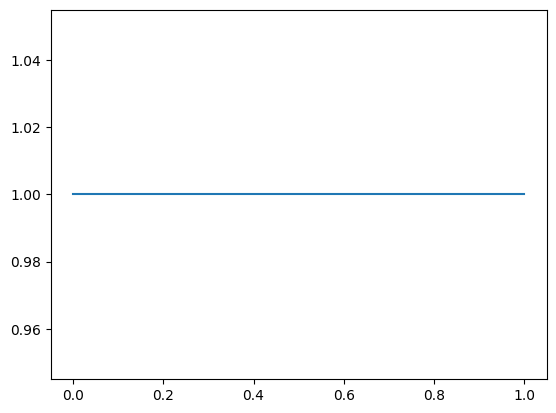

1.0


In [15]:
prec = [1.0,1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
recall = [0,0.06666666666666667, 0.13333333333333333, 0.2, 0.26666666666666666, 0.3333333333333333, 0.4, 0.4666666666666667, 0.5333333333333333, 0.6, 0.6666666666666666, 0.7333333333333333, 0.8, 0.8666666666666667, 0.9333333333333333,1.0]
import matplotlib.pyplot as plt 
plt.plot(recall,prec)
plt.show()
prec = np.asarray(prec)
recall = np.asarray(recall)
print(np.trapz(prec,recall)) 
